In [1]:
import numpy as np
import cupy as cp
import cupyx.scipy.signal as signal
import scipy
from scipy.optimize import curve_fit
import pandas as pd
import pywt

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from astropy.modeling import models, fitting
import astropy.units as u
from astropy import constants as const
from astropy.stats import gaussian_sigma_to_fwhm,gaussian_fwhm_to_sigma

import datetime
import pickle
import importlib
import json
import time
import glob
from skimage.metrics import structural_similarity as ssim

In [2]:
with open('D:\py_repo\EVE-spectrum-correction\Chapter4_v2\\basic_ops\eve_ops\data\daily_df.pkl', 'rb') as file:
    eve_daily_df=pickle.load(file)

In [3]:
with open('D:\py_repo\EVE-spectrum-correction\Chapter4_v2\\basic_ops\\aia_ops\data\\aia.pkl','rb') as file:
     aia_df=pickle.load(file)

In [4]:
aia_df

,time,image,filename
0,2010-06-01 00:00:08.120,"[[0.003302, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001377,...",./data/AIA_1p5\aia_lev1_304a_2010_06_01t00_00_...
1,2010-06-02 00:05:38.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.276e-05...",./data/AIA_1p5\aia_lev1_304a_2010_06_02t00_05_...
2,2010-06-03 00:00:02.130,"[[0.0, 0.0, 3.535e-05, 0.0, 0.0, 5.496e-05, 0....",./data/AIA_1p5\aia_lev1_304a_2010_06_03t00_00_...
3,2010-06-04 00:00:02.130,"[[0.0, 0.0, 0.0, 0.0004733, 0.0, 0.0, 0.0, 0.0...",./data/AIA_1p5\aia_lev1_304a_2010_06_04t00_00_...
4,2010-06-05 00:00:05.500,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",./data/AIA_1p5\aia_lev1_304a_2010_06_05t00_00_...
...,...,...,...
1455,2014-05-27 00:00:07.140,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2014_05_27t00_00_...
1456,2014-05-28 00:00:07.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2014_05_28t00_00_...
1457,2014-05-29 00:00:07.130,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2014_05_29t00_00_...
1458,2014-05-30 00:00:07.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2014_05_30t00_00_...


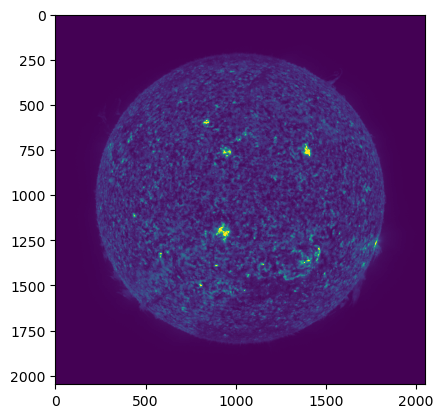

In [11]:
plt.imshow(aia_df.iloc[0]['image'],vmax=400)

In [21]:
x=np.arange(2048)
y=np.arange(2048)
X,Y=np.meshgrid(x,y)

In [40]:
time_list=aia_df['time']
time_list

0      2010-06-01 00:00:08.120
1      2010-06-02 00:05:38.120
2      2010-06-03 00:00:02.130
3      2010-06-04 00:00:02.130
4      2010-06-05 00:00:05.500
                 ...          
1455   2014-05-27 00:00:07.140
1456   2014-05-28 00:00:07.120
1457   2014-05-29 00:00:07.130
1458   2014-05-30 00:00:07.120
1459   2014-05-31 00:00:07.120
Name: time, Length: 1460, dtype: datetime64[ns]

In [41]:
new_x=[]
new_y=[]
for i in list(range(len(aia_df)))[:]:
    data=aia_df.iloc[i]['image']
    new_x.append(np.sum(X*data))
    new_y.append(np.sum(Y*data))

In [43]:
new_df={'time':time_list,
        'X':new_x,
        'Y':new_y,
}
new_df=pd.DataFrame(new_df)
new_df

,time,X,Y
0,2010-06-01 00:00:08.120,1.152712e+11,1.162875e+11
1,2010-06-02 00:05:38.120,1.151843e+11,1.154525e+11
2,2010-06-03 00:00:02.130,1.142503e+11,1.148000e+11
3,2010-06-04 00:00:02.130,1.138677e+11,1.139646e+11
4,2010-06-05 00:00:05.500,NaN,NaN
...,...,...,...
1455,2014-05-27 00:00:07.140,1.300880e+11,1.236089e+11
1456,2014-05-28 00:00:07.120,1.311883e+11,1.239081e+11
1457,2014-05-29 00:00:07.130,1.287492e+11,1.223319e+11
1458,2014-05-30 00:00:07.120,1.313218e+11,1.243114e+11


In [35]:
mean=eve_daily_df['median_of_mean'].values

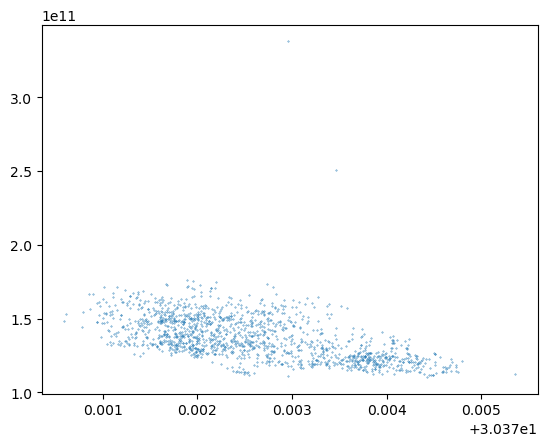

In [39]:
plt.scatter(mean[:len(new_list)],new_list,s=0.1)

In [36]:
len(mean)

1707

In [45]:
eve_daily_df

,median_of_mean,median_of_stddev,median_of_amplitude,stddev_of_mean,stddev_of_stddev,stddev_of_amplitude,available_data
time,,,,,,,
2010-04-30,30.374138,0.028910,0.006518,0.000175,0.000076,0.000058,8570
2010-05-01,30.374133,0.028986,0.006556,0.000199,0.000070,0.000052,8579
2010-05-02,30.374000,0.029030,0.006503,0.000210,0.000070,0.000048,8579
2010-05-03,30.373922,0.029038,0.006513,0.000206,0.000102,0.000049,8640
2010-05-04,30.373876,0.029006,0.006656,0.000195,0.000092,0.000059,8578
...,...,...,...,...,...,...,...
2014-12-27,NaN,NaN,NaN,NaN,NaN,NaN,0
2014-12-28,NaN,NaN,NaN,NaN,NaN,NaN,0
2014-12-29,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
common_time_df = pd.merge(A, B, on='time', suffixes=('_A', '_B'))

In [ ]:
new_df['time']

,time,X,Y
0,2010-06-01 00:00:08.120,1.152712e+11,1.162875e+11
1,2010-06-02 00:05:38.120,1.151843e+11,1.154525e+11
2,2010-06-03 00:00:02.130,1.142503e+11,1.148000e+11
3,2010-06-04 00:00:02.130,1.138677e+11,1.139646e+11
4,2010-06-05 00:00:05.500,NaN,NaN
...,...,...,...
1455,2014-05-27 00:00:07.140,1.300880e+11,1.236089e+11
1456,2014-05-28 00:00:07.120,1.311883e+11,1.239081e+11
1457,2014-05-29 00:00:07.130,1.287492e+11,1.223319e+11
1458,2014-05-30 00:00:07.120,1.313218e+11,1.243114e+11


In [57]:
def f(x):
    return x.date()
new_df['time']=new_df['time'].apply(f)
new_df

,time,X,Y
0,2010-06-01,1.152712e+11,1.162875e+11
1,2010-06-02,1.151843e+11,1.154525e+11
2,2010-06-03,1.142503e+11,1.148000e+11
3,2010-06-04,1.138677e+11,1.139646e+11
4,2010-06-05,NaN,NaN
...,...,...,...
1455,2014-05-27,1.300880e+11,1.236089e+11
1456,2014-05-28,1.311883e+11,1.239081e+11
1457,2014-05-29,1.287492e+11,1.223319e+11
1458,2014-05-30,1.313218e+11,1.243114e+11


In [71]:
eve_daily_df.reset_index(inplace=True)
eve_daily_df['time']=eve_daily_df['time'].apply(f)

In [72]:
eve_daily_df['time'][0]

datetime.date(2010, 4, 30)

In [76]:
m=pd.merge(eve_daily_df,new_df,on='time')
m

,level_0,index,time,median_of_mean,median_of_stddev,median_of_amplitude,stddev_of_mean,stddev_of_stddev,stddev_of_amplitude,available_data,X,Y
0,32,32,2010-06-01,30.372410,0.028617,0.006253,0.000152,0.000095,0.000053,8576,1.152712e+11,1.162875e+11
1,33,33,2010-06-02,30.372425,0.028615,0.006185,0.000168,0.000092,0.000053,8576,1.151843e+11,1.154525e+11
2,34,34,2010-06-03,30.372540,0.028580,0.006150,0.000847,0.000177,0.000085,8217,1.142503e+11,1.148000e+11
3,35,35,2010-06-04,30.374629,0.028537,0.006146,0.000871,0.000184,0.000085,8217,1.138677e+11,1.139646e+11
4,36,36,2010-06-05,30.374757,0.028548,0.006080,0.000854,0.000184,0.000087,8218,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1488,1488,2014-05-27,NaN,NaN,NaN,NaN,NaN,NaN,0,1.300880e+11,1.236089e+11
1456,1489,1489,2014-05-28,NaN,NaN,NaN,NaN,NaN,NaN,0,1.311883e+11,1.239081e+11
1457,1490,1490,2014-05-29,NaN,NaN,NaN,NaN,NaN,NaN,0,1.287492e+11,1.223319e+11
1458,1491,1491,2014-05-30,NaN,NaN,NaN,NaN,NaN,NaN,0,1.313218e+11,1.243114e+11


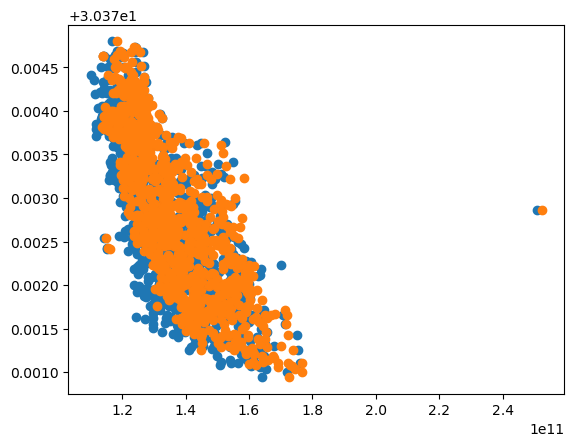

In [82]:
fig,ax=plt.subplots()
n=1000
ax.scatter(m['X'][:n],m['median_of_mean'][:n])
ax.scatter(m['Y'][:n],m['median_of_mean'][:n])

DatetimeIndex(['2010-04-30', '2010-05-01', '2010-05-02', '2010-05-03',
               '2010-05-04', '2010-05-05', '2010-05-06', '2010-05-07',
               '2010-05-08', '2010-05-09',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', name='time', length=1707, freq='D')

In [67]:
import pandas as pd

# Example data for DataFrame A (10 rows)
A = pd.DataFrame({
    'time': pd.date_range(start='2022-01-01', periods=10),
    'value_A': range(10)
})

# Example data for DataFrame B (20 rows, some overlapping with A's time values)
B = pd.DataFrame({
    'time': pd.date_range(start='2022-01-05', periods=20),
    'value_B': range(20),
    'xxxx':range(20)
})

# Merge A and B on the 'time' column to get only the common time values
common_time_df = pd.merge(A, B, on='time', suffixes=('_A', '_B'))

# Separate the merged DataFrame into A_new and B_new, containing only the columns from A and B, respectively
A_new = common_time_df[[col for col in common_time_df.columns if col.endswith('_A')]].rename(columns=lambda x: x[:-2])
B_new = common_time_df[[col for col in common_time_df.columns if col.endswith('_B')]].rename(columns=lambda x: x[:-2])

# Print the new DataFrames
print("A_new:")
print(A_new)
print("\nB_new:")
print(B_new)


A_new:
   value
0      4
1      5
2      6
3      7
4      8
5      9

B_new:
   value
0      0
1      1
2      2
3      3
4      4
5      5


In [68]:
common_time_df

,time,value_A,value_B,xxxx
0,2022-01-05,4,0,0
1,2022-01-06,5,1,1
2,2022-01-07,6,2,2
3,2022-01-08,7,3,3
4,2022-01-09,8,4,4
5,2022-01-10,9,5,5


In [48]:
A

,time,value_A
0,2022-01-01,0
1,2022-01-02,1
2,2022-01-03,2
3,2022-01-04,3
4,2022-01-05,4
5,2022-01-06,5
6,2022-01-07,6
7,2022-01-08,7
8,2022-01-09,8
9,2022-01-10,9


In [49]:
B

,time,value_B
0,2022-01-05,0
1,2022-01-06,1
2,2022-01-07,2
3,2022-01-08,3
4,2022-01-09,4
5,2022-01-10,5
6,2022-01-11,6
7,2022-01-12,7
8,2022-01-13,8
9,2022-01-14,9


### Wavelet Wuwuwu

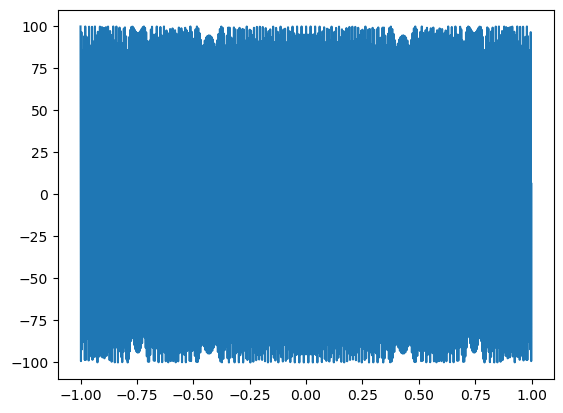

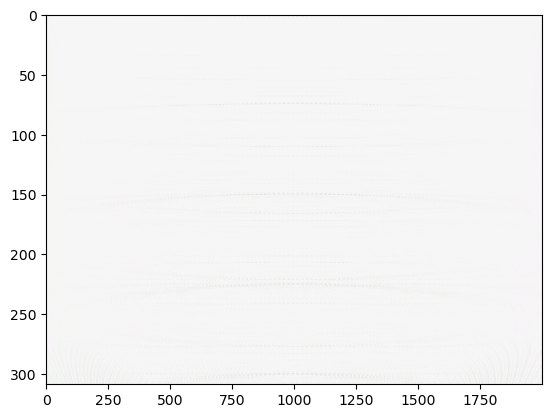

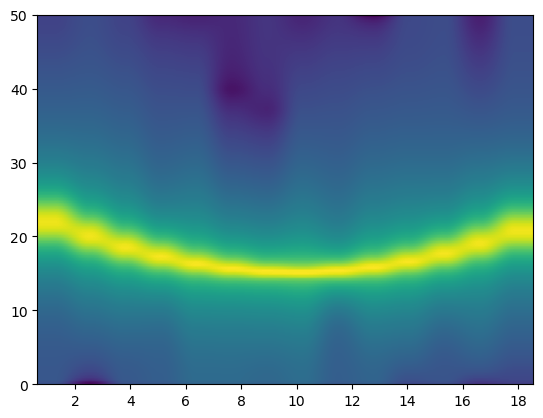

In [65]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
t = np.linspace(-1, 1, 2000, endpoint=False)
sig  = 100*np.cos(2 * np.pi * (150+30*t*t) * t) 


fig,ax=plt.subplots()
ax.plot(t,sig)



fig,ax=plt.subplots()
widths = np.arange(1, 310)
cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
ax.imshow(cwtmatr,  cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  



Fs=(t[-1]-t[0])/len(t)
fig,ax=plt.subplots()
ax.specgram(sig,Fs=100);
